In [1]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from transformer.reimei import ReiMei, ReiMeiParameters
import matplotlib.pyplot as plt
from config import AE_CHANNELS, DIT_S as DIT, MODELS_DIR_BASE, SIGLIP_HF_NAME, SIGLIP_EMBED_DIM
from torch.amp import autocast
from transformers import SiglipTokenizer, SiglipTextModel
from diffusers import AutoencoderDC
import time

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
# base_dim = 1024
# base_heads = 32

input_dim = AE_CHANNELS
num_layers = 8
embed_dim = 1024
num_heads = embed_dim // 128
num_experts = 8
capacity_factor = 2.0
shared_experts = 1
token_mixer_layers = 1
image_text_expert_ratio = 4
dropout = 0.1

# m_d = float(embed_dim) / float(base_dim)

# assert (embed_dim // num_heads) == (base_dim // base_heads)

params = ReiMeiParameters(
    channels=input_dim,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    siglip_dim=SIGLIP_EMBED_DIM,
    num_experts=num_experts,
    capacity_factor=capacity_factor,
    shared_experts=shared_experts,
    dropout=dropout,
    token_mixer_layers=token_mixer_layers,
    image_text_expert_ratio=image_text_expert_ratio,
    # m_d=m_d,
    use_mmdit=True,
    use_ec=True,
    use_moe=None,
)
DTYPE = torch.bfloat16

In [6]:
model = ReiMei(params)
model.load_state_dict(torch.load("models/reimei_model_and_optimizer_4_f32.pt")['model_state_dict'])

<All keys matched successfully>

In [7]:
# Print the number of parameters in the model
print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters()))


Number of parameters in the model:  194463256


In [8]:
siglip_model = SiglipTextModel.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip").to(device)
siglip_tokenizer = SiglipTokenizer.from_pretrained(SIGLIP_HF_NAME, cache_dir=f"{MODELS_DIR_BASE}/siglip")

In [9]:
padded_len = 64


In [417]:
prompts = [
    "a dog swimming in a swimming pool" 
] * 9

In [418]:
t = time.time()

siglip_inputs = []
unpadded_lens = []
for prompt in prompts:
    input = siglip_tokenizer.encode(prompt, return_tensors="pt").to("cuda").squeeze()
    # unpadded_lens.append(input.shape[-1])
    # if input.shape[0] < padded_len:
    #     padding = torch.zeros(padded_len - input.shape[0], dtype=input.dtype, device=input.device)
    #     input = torch.cat([input, padding])
    # else:
    #     input = input[:padded_len]
    siglip_inputs.append(input)

siglip_inputs = torch.stack(siglip_inputs)
siglip_outputs = siglip_model(siglip_inputs, output_hidden_states=True)
siglip_embeddings = siglip_outputs.hidden_states[-1]
siglip_vec = siglip_outputs.pooler_output
print(f"Took: {time.time() - t}")

Took: 0.01902151107788086


In [419]:
siglip_embeddings.shape, 

(torch.Size([9, 10, 1152]),)

In [420]:
# del siglip_model, siglip_tokenizer

In [421]:
print("siglip emb", torch.std_mean(siglip_embeddings))
print("siglip vec", torch.std_mean(siglip_vec))

siglip emb (tensor(1.0911, device='cuda:0'), tensor(0.6808, device='cuda:0'))
siglip vec (tensor(0.8452, device='cuda:0'), tensor(-0.0228, device='cuda:0'))


In [422]:
vae = AutoencoderDC.from_pretrained("mit-han-lab/dc-ae-f64c128-mix-1.0-diffusers", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").eval()
# print param count
print(sum(p.numel() for p in vae.parameters()))

676896140


In [423]:
model = model.eval().to(device, dtype=DTYPE)

In [431]:
noise = torch.randn(9, 128, 4, 4).to(device).to(DTYPE)
with torch.inference_mode():
    with autocast("cuda", dtype=DTYPE):
        # pred = model(noise, torch.ones((1,), device="cuda"), siglip_embeddings, siglip_vec, None)
        pred = model.sample(noise, siglip_embeddings, siglip_vec, sample_steps=200, cfg=10.0)

In [432]:
# model = model.to("cpu")
# del model

In [433]:
torch.std_mean(pred)

(tensor(2.9688, device='cuda:0', dtype=torch.bfloat16),
 tensor(0.5430, device='cuda:0', dtype=torch.bfloat16))

In [434]:
vae = vae.to(device)

In [435]:
# model = model.eval()
with autocast("cuda", dtype=DTYPE):
    # pred = model.sample(noise, siglip_embeddings, siglip_vec, sample_steps=50, cfg=7.0)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1

In [436]:
vae = vae.to("cpu")

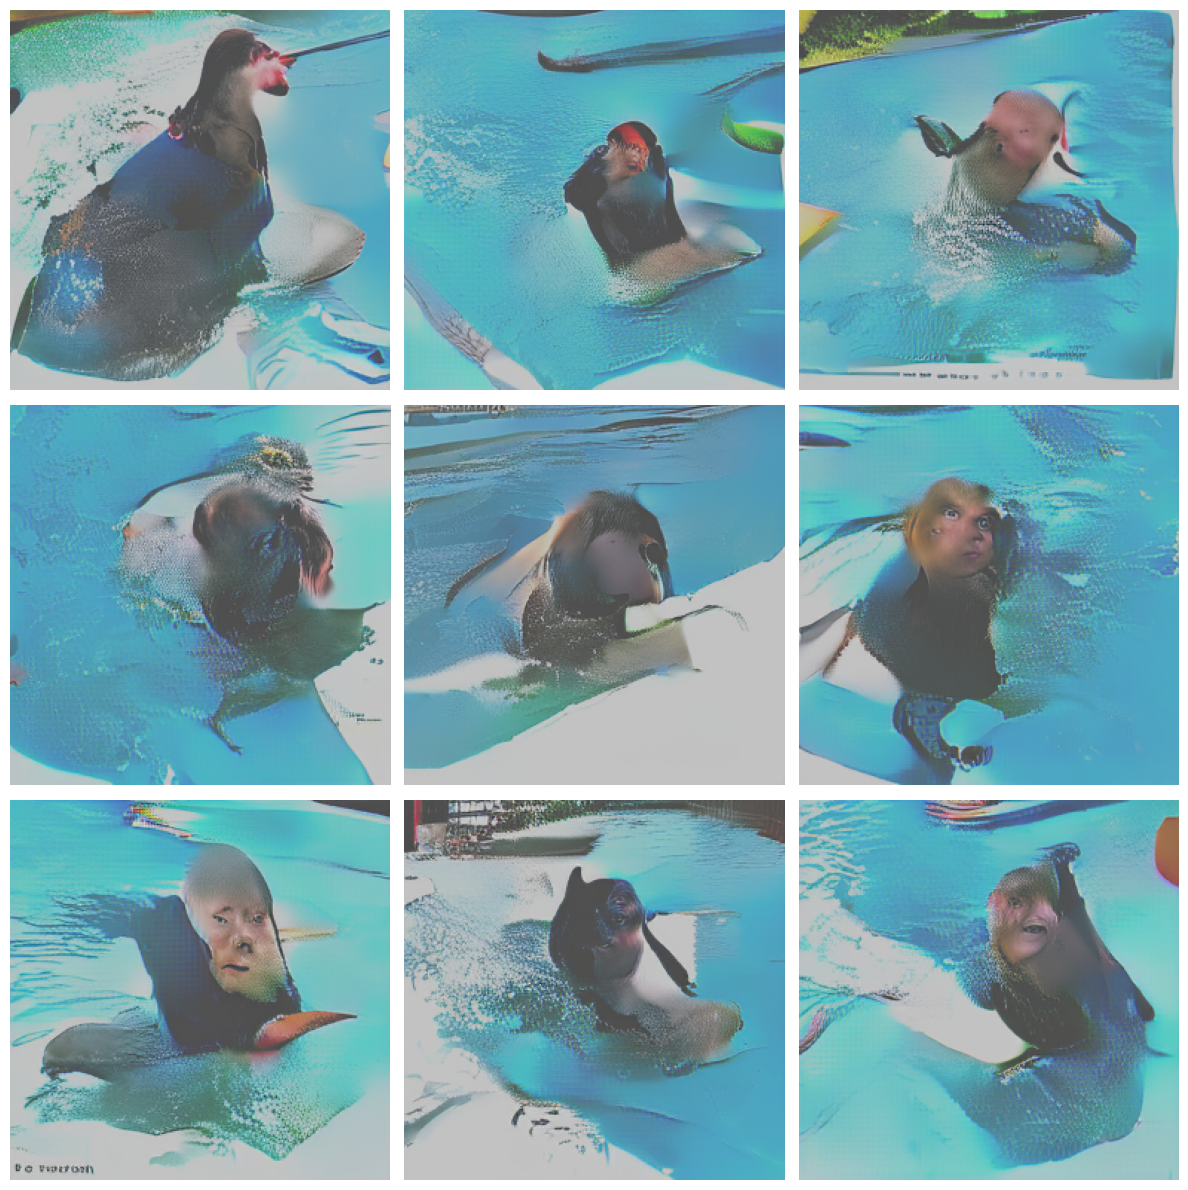

In [437]:
with torch.inference_mode():
    pred_cpu = pred.cpu().to(torch.float32)
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            # ax.set_title(prompts[i])  # Add this line to set the title
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()